In [1]:
import shutil
import pickle
import numpy as np
from collections import Counter
from string import ascii_letters
from timeit import time

from tqdm import tqdm_notebook
from utils import utils
import matplotlib.pyplot as plt
%matplotlib inline

/Users/mzmeev/miniconda3/envs/pytorch/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
P_RAW_TEXTS = './data/raw_text.txt'
P_FILE_IDXES = 'data/file_idxes.npy'
P_TOKENIZER = 'data/tokenizer.pickle'
P_LABEL2IDX = 'data/label2idx.pickle'
P_LABEL_COUNTER = 'data/label_counter.pickle'
P_DATA = './data'
FIELDS_DELIMETR = '\t\t'
LABELS_DELIMETR = '##'

In [3]:
N_SPLITS = 4# 40
LABEL_COUNT_THRESHOLD = 0
EMBEDDING_DIM = 200
FILES_IN_FOLDER = 5# 3000
WORDS_IN_BATCH = 350# 350 * 64
MAX_BATCH_SIZE = 100# 256
N_WORDS = 3000

    Make fake raw texts and word vectors

In [4]:
letter_list = list(ascii_letters)[:4]
def generate_word():
    word_len = np.random.randint(3, 7)
    return ''.join(np.random.choice(letter_list, word_len))

def generate_sentence():
    sent_len = np.random.binomial(10, 0.5) + 1
    return ' '.join([generate_word() for _ in range(sent_len)]) + '.'

def generate_text():
    sent_number = np.random.binomial(5, 0.5) + 1
    return ' '.join([generate_sentence() for _ in range(sent_number)])

generate_text()

'cab bbdadd baddc cacad dccc dcd ccabab. dbdba dac accadb dcc bcccc ddacbb. cccabb dbdba dbacb aaaccd bbcdd. bcb abcdac cccb dbad ccbc bbcdba.'

In [5]:
with open(P_RAW_TEXTS, 'w') as fraw:
    for i in tqdm_notebook(range(5000)):
        labels = LABELS_DELIMETR.join([generate_word() for _ in range(np.random.randint(3, 7))])
        text, title = generate_text(), generate_sentence()
        fraw.write(FIELDS_DELIMETR.join([labels, title, text]) + '\n')

In [6]:
with open('./data/word_vectors.txt', 'w') as fwv:
    for i in tqdm_notebook(range(10000)):
        word = generate_word().lower()
        vec = np.random.randn(200)
        fwv.write('\t'.join([word, ' '.join(vec.astype('float32').astype(str))]) + '\n')

### Start preprocessing


Done at 1.26031 seconds


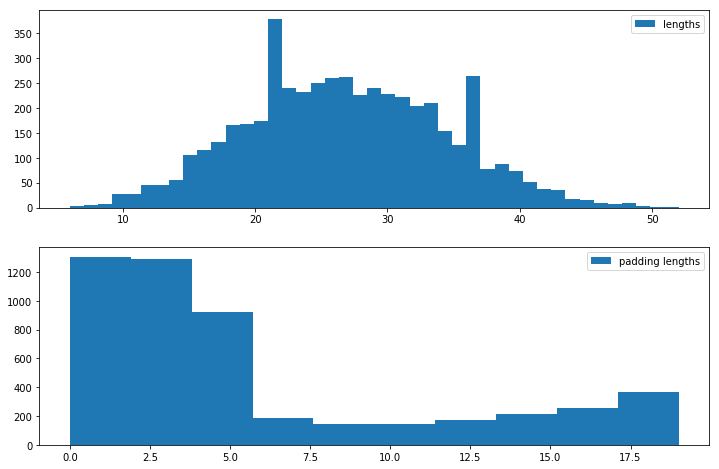

In [7]:
start_time = time.time()

hash_set = set()
filtered_texts, filtered_labels = [], []


# Read and drop duplicated texts
with open(P_RAW_TEXTS, 'r') as fraw:
    for line in tqdm_notebook(fraw, desc='read raw text'):
        line = line.replace('\n', '').lower().strip()
        labels, title, text = line.split(FIELDS_DELIMETR)
        text_hash = utils.get_hash(text)
        if text_hash not in hash_set:
            hash_set.add(text_hash)
            filtered_texts.append(' '.join([title, text]))
            filtered_labels.append(labels)


# Populate label_counter
label_counter = Counter()
for label_line in tqdm_notebook(filtered_labels, desc='label counter'):
    label_counter.update(label_line.split(LABELS_DELIMETR))
label2idx = {label: idx for idx, (label, count) in enumerate(label_counter.most_common())
             if count >= LABEL_COUNT_THRESHOLD}


# Tokenize and get lengths
tokenizer = utils.Tokenizer()
lens = np.array([len(tokenizer.tokenize(t, update_words=True))
                 for t in tqdm_notebook(filtered_texts, desc='tokenizing')])
tokenizer.shrink(N_WORDS)


# Get padded lengths
pad_lens = utils.get_pad_lens(lens, n_splits=N_SPLITS)
unique_pad_lens = np.unique(pad_lens)


# Plot lengths distribution
fig, axes = plt.subplots(2, figsize=[12, 8])
_ = axes[0].hist(lens, bins=43, label='lengths')
_ = axes[1].hist(pad_lens - lens, bins=10, label='padding lengths')
_ = axes[0].legend(), axes[1].legend()



# Match texts with length group
pad_len2idxes = {}
for pad_len in unique_pad_lens:
    pad_len2idxes[pad_len] = np.arange(len(filtered_texts))[pad_lens==pad_len]
    np.random.shuffle(pad_len2idxes[pad_len])


# Write all texts in batches
for pad_len, idxes in tqdm_notebook(pad_len2idxes.items(), desc='writing batches'):
    path = shutil.os.path.join(P_DATA, 'len' + str(pad_len))
    if shutil.os.path.exists(path):
        shutil.rmtree(path)
    shutil.os.mkdir(path)
    utils.write_batches(idxes, path, min(MAX_BATCH_SIZE, WORDS_IN_BATCH // pad_len),
                        filtered_labels, filtered_texts, FILES_IN_FOLDER)


# Collect indices for batches
file_idxes = []
for pad_len in unique_pad_lens:
    pad_len_dir = shutil.os.path.join(P_DATA, 'len' + str(pad_len))
    for dir_name in shutil.os.listdir(pad_len_dir):
        for file_name in shutil.os.listdir(shutil.os.path.join(pad_len_dir, dir_name)):
            file_idxes.append([pad_len, int(dir_name), int(file_name)])
file_idxes = np.array(file_idxes)
np.random.shuffle(file_idxes)


# Save collected objects
np.save(P_FILE_IDXES, file_idxes)
utils.pickle_obj(label2idx, P_LABEL2IDX)
utils.pickle_obj(label_counter, P_LABEL_COUNTER)
utils.pickle_obj(tokenizer, P_TOKENIZER)

end_time = time.time()
print('Done at %g seconds' % (end_time - start_time))

### many sentences

In [35]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/mzmeev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
max_lens = np.zeros(len(filtered_texts), dtype='int32')
for idx in range(len(filtered_texts)):
    sentences = nltk.sent_tokenize(filtered_texts[idx])
    max_lens[idx] = max(map(len, map(tokenizer.tokenize, sentences)))

pad_max_lens = get_pad_lens(max_lens)
unique_pad_max_lens = np.unique(pad_max_lens)
pad_max_len2idx = {pad_max_len: np.zeros(np.sum(pad_max_lens==pad_max_len), 'int64')
                   for pad_max_len in unique_pad_max_lens}
for pad_max_len in unique_pad_max_lens:
    pad_max_len2idx[pad_max_len] = np.arange(len(pad_max_lens))[pad_max_lens==pad_max_len]
    np.random.shuffle(pad_max_len2idx[pad_max_len])
pad_max_len2size = {pad_max_len: len(idxes) for pad_max_len, idxes in pad_max_len2idx.items()}

In [37]:
pad_max_len2size

{5: 655, 6: 1463, 7: 1640, 8: 930, 9: 268, 11: 44}

In [38]:
import shutil

In [115]:
N_SENT_AVG = 3


def write_many_sent_batch(path, batch_x, batch_y):
    with open(path, 'w') as fout:
        for i, (text, label_list) in enumerate(zip(batch_x, batch_y)):
            label_list = [label2idx[l] for l in label_list]
            fout.write(labels_delimetr.join(map(str, label_list)) + '\n')
            for sent in nltk.sent_tokenize(text):
                sent = tokenizer.tokenize(sent)
                fout.write(' '.join(map(str, sent)) + '\n')
            if i + 1 != len(batch_x):
                fout.write('\n')


def write_many_sent_idxes(path, idxes, texts, labels, batch_size):
    for batch_idx, start_idx in tqdm_notebook(enumerate(range(0, len(idxes), batch_size)), desc='writing idxes'):
        end_idx = min(start_idx + batch_size, len(idxes))
        batch_x = [texts[idx] for idx in idxes[start_idx:end_idx]]
        batch_y = [labels[idx] for idx in idxes[start_idx:end_idx]]
        batch_path = shutil.os.path.join(path, str(batch_idx))
        write_many_sent_batch(batch_path, batch_x, batch_y)


def write_many_sent(path, pad_max_len2idx, texts,
                    labels, words_in_batch):
    if shutil.os.path.exists(path):
        shutil.rmtree(path)
    shutil.os.mkdir(path)
    for pad_max_len, idxes in tqdm_notebook(pad_max_len2idx.items(), desc=''):
        pad_max_len_path = shutil.os.path.join(path, str(pad_max_len))
        shutil.os.mkdir(pad_max_len_path)
        write_many_sent_idxes(pad_max_len_path, idxes, texts, labels,
                              words_in_batch // (pad_max_len * N_SENT_AVG))



In [116]:
filtered_labels = [l.split(labels_delimetr) for l in filtered_labels] \
if not isinstance(filtered_labels[0], list) else filtered_labels

In [117]:
write_many_sent('many_sent', pad_max_len2idx, filtered_texts, filtered_labels, 75)

In [118]:
paths = []
def collect_batch_paths(path):
    paths = []
    for pad_max_len in unique_pad_max_lens:
        for subpath in shutil.os.listdir(shutil.os.path.join(path, str(pad_max_len))):
            paths.append(shutil.os.path.join(path, str(pad_max_len), subpath))
    return paths
paths = collect_batch_paths('many_sent/')

In [119]:
! cat many_sent/11/0

1517##40##592##641##37
91 19 398 58 233 453
1067 476 644 8 26 165 795
34 34 237 119 530 227 2507 212 137 40
210 261 35
784 2645 161 41 2287

321##62##12
482 117 296 42 80 271 174
9 1266 180 1021 495 32 12 1275 36 898
320 23 26 55
184 8 711 21


In [123]:
def read_batch(path):
    batch_x, batch_y = [], []
    with open(path, 'r') as f:
        line = f.readline().replace('\n', '')
        while line != '':
            lbls = list(map(int, line.split(labels_delimetr)))
            sentences = []
            line = f.readline().replace('\n', '')
            while line != '':
                sentences.append(list(map(int, line.split())))
                line = f.readline().replace('\n', '')
            line = f.readline().replace('\n', '')
            batch_x.append(sentences)
            batch_y.append(lbls)
    return batch_x, batch_y


def read_batches(paths):
    for path in paths:
        yield read_batch(path)

In [125]:
for bx, by in read_batches(paths):
    print(len(bx))
    print(len(by))
    break

5
5


In [11]:
word2vec = {}
with open(p_word_vectors, 'r') as fwv:
    for line in tqdm_notebook(fwv, desc='read vectors'):
        word, vec = line.strip().split('\t')
        word2vec[word] = vec
words2remove = set()
for word in tqdm_notebook(tokenizer.word_count, desc='looking for words to remove'):
    if word not in word2vec:
        words2remove.add(word)
for word in tqdm_notebook(words2remove, desc='removing words'):
    tokenizer.word2idx.pop(word)
    tokenizer.word_count.pop(word)